## Drum Classification Notebook
(General descriptions in README.md)

### Data Collection:
There are 197 audio files, consisted of kick, tom, snare, hihats, and cymbal(all handpicked mostly from freesound.org). All the files are one-hit sound of individual part of the drums. I picked the files that I could clearly identify the part they come from. For each drum part, I tried to collect at least 30 audio files.


| Types |kick|tom|snare|hihats|cymbal
|------|------|------|------|------|------
|   # of Files  |37|30|56|44|30



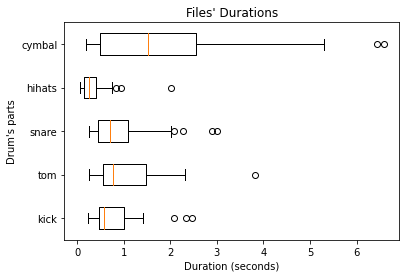

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv

'''This part visualizes the durations of each part'''

durationList = []
with open('duration.csv', 'r') as readObj:#the csv file was writen by loadData.py
    csvReader = csv.reader(readObj, quoting=csv.QUOTE_NONNUMERIC)
    durationList = list(csvReader)
    

columns = ['kick', 'tom', 'snare', 'hihats', 'cymbal']
fig, ax = plt.subplots()

ax.set_title("Files' Durations")
plt.xlabel('Duration (seconds)')
plt.ylabel("Drum's parts")


ax.boxplot(durationList, vert=False)
plt.yticks([1, 2, 3, 4, 5], columns)

plt.show()

Note: cymbal files are longer than the others due to their reverberate sounds 

### Data Preparation:
For the computer to understand an audio file, I am transforming the audio to a spectrogram(a picture) that contains amplitude, frequency, and time. Amplitude captures the loudness. Frequency captures the pitch. Time captures amplitude and frequency at a specific point in time. The normal spectrogram would have frequency as a y-axis, time as an x-axis, and amplitude as the colors on the spectrogram.

Mel Frequency Cepstral Coefficients(mfcc) takes a further step from the spectrogram by scaling the frequency down to Mel Frequency(from 0 to 13). With this scale, it is said to be a very good representation of what human can hear. Therefore, by transforming an audio file into mfcc, I am making a representation of what a human would hear from the audio file as a picuture that the computer will understand.

The mfcc samples can be seen below.

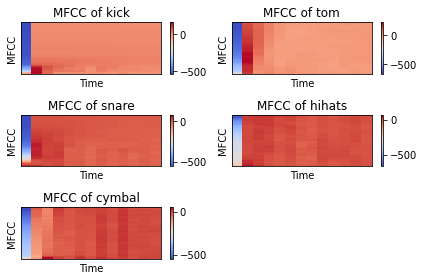

In [10]:
import json
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

'''This part visualizes the mfcc of each label'''

DATASET_PATH = "drum_data.json"
HOP_LENGTH = 512
SAMPLE_SIZE = 22050
#kick = [0,36] tom = [37,66] snare = [67,122] hihats = [123,166] cymbal = [167,196]
indexList = [0, 37, 67, 123, 167]#changable


#gets data from the json file
with open(DATASET_PATH, "r") as fp:
    data = json.load(fp)

X = np.array(data["mfcc"])
y = np.array(data["labels"])

#plots the data according to the indexList
dimensionCount = 321 #the last digit defines which position it is on

for index in indexList:
    plt.subplot(dimensionCount)#identifies the subplot
    mfccSample = X[index]#gets data
    #shows spectrogram
    librosa.display.specshow(mfccSample, sr=SAMPLE_SIZE, hop_length=HOP_LENGTH) 
    
    #labels axes
    plt.xlabel("Time")
    plt.ylabel("MFCC")

    #changes name based on the index
    plt.title('MFCC of {}'.format('kick' if y[index]==0 else 'tom' if y[index]==1 else
                                 'snare' if y[index]==2 else 'hihats' if y[index]==3 else
                                 'cymbal' if y[index]==4 else 'NONE'))
    plt.colorbar()
    plt.tight_layout()
    dimensionCount+= 1 #moves to the next position of the subplot
    
plt.show()

To extract the Mel Frequency Cepstral Coefficients(mfcc) from an audio file, there has to be a fixed time frame(sample rate), i.e. first 3 seconds of an audio file. I am using 1 second as a time frame since many of the files are right about 1 second long.

(See the duration graph above for a clearer visualization)

With a requirement that every file has to be exacly 1 second, I either _cut_ the files that were too long or _stretch_ the files that were too short. 

By streatching, there needs to be an additional function to recursively stretches the file until it gets to 1 second(almost all hihats data are shorter than 1 second). 


To ensure that the data are still valid, I converted the modified mfcc back to wav files and checked whether they still sound like what they are or not(they still do).

In [50]:
import IPython.display as ipd
#sample of the shortest hihat(0.06 seconds) after stretched 
ipd.Audio('displayAudio/strectch_sample_hihats-3.wav')
#other files: strectch_sample_hihats-3.wav , strectch_sample_hihats-5.wav

In [3]:
import IPython.display as ipd
#sample of the longest cymbal(6.4 seconds) got cut to 1 second
ipd.Audio('displayAudio/cut_cymbal.wav')
#other files: cut_cymbal.wav , cut_kick.wav , cut_snare.wav , cut_tom.wav

Note: there are more samples in displayAudio, and all the original samples are in Drum_Dataset

After modified the data, I used librosa API to extract the Mel Frequency Cepstral Coefficients(mfcc) feature from the audio data and stored all of them as a json file so that the program doesn't have to load all the audio files everytime it runs.

With the json file, there is a prepareDatasets function to randomly split the dataset into  train(train + validation) and test datasets(X represents mfcc values and Y represents the labels(kick, snare, etc.) of the data. 

In [12]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

DATASET_PATH = "drum_data.json"

def loadData(datasetPath):
    
    '''
    loads json data from the given datasetPath
    
    Parameter: 
        String of the json file
    
    Returns: 
        X represents a np array of mfcc value
        y represents a np array of labels
    '''
    
    with open(datasetPath, "r") as fp:
        data = json.load(fp)

    #coverts lists to numpy array
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    return X, y

def prepareDatasets(test_size, validation_size):
    
    '''
    splits the dataset to test, validation, and train
    
    Parameter: 
        test_size is a float of the amount of data that will be used for testing(ex: 0.25 = 25 percent)
        validation _size is  a float of the amount of data of the train set that will be used for validation
    
    Returns: 
        X and y of train, validation, and test
    '''

    X, y = loadData(DATASET_PATH)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    #adds extra dimension(tensorflow expects 3d arrays)
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

### Choose a Model:
The purpose of this project is not to find the "best" model for the job. I started this project to explore the fields of machine learning and deep learning through the branch of audio processing that I am interested in. 

In this project, I used Convolutional Neural Network(CNN) to analyse the extracted mfcc as if they were images. 

### Build the Model:

In [43]:
def modelImplementations(inputShape):
    '''
    The model contains 3 hidden layers. Each hidden layer has a convolutional layer, containing kernels with
    adjustable weights, a max-pooling layer, used to scale down the input, and a batch normalization, used to
    speed up the learning by allowing the values to "shift" around.
    
    Parameter:
        inputShape = shape of X_train, excluding the 0th shape that is a number of sample
    
    Return:
        model = empty model
    '''
    model = keras.Sequential()

    #1st conv layer
    model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=inputShape))
    model.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    #2nd conv layer
    model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=inputShape))
    model.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    
    #3rd conv layer
    model.add(keras.layers.Conv2D(32, (2,2), activation='relu', input_shape=inputShape))
    model.add(keras.layers.MaxPool2D((2,2), strides=(2,2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flattens to 1d array and feeds into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))# layer for classification
    model.add(keras.layers.Dropout(0.2))# solve overfitting

    # output layer (equals to output)
    model.add(keras.layers.Dense(5, activation='softmax'))

    return model

### Train and Evaluate the Model

In [48]:
#creates train, validation, and test sets
X_train, X_validation, X_test, y_train, y_validation, y_test = prepareDatasets(0.25, 0.2)

#builds the CNN net (0th column is a number of sample)
inputShape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

#creates a model
model = modelImplementations(inputShape)

#trains the model
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=120)

#evaluates the model with test set
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print("+++++++++++++++++")
print("Accuracy on test set: {}".format(test_accuracy))



Epoch 1/120
4/4 [==============================] - 0s 109ms/step - loss: 2.6886 - accuracy: 0.1966 - val_loss: 6.7916 - val_accuracy: 0.2667
Epoch 2/120
4/4 [==============================] - 0s 35ms/step - loss: 2.4915 - accuracy: 0.1966 - val_loss: 4.7892 - val_accuracy: 0.2667
Epoch 3/120
4/4 [==============================] - 0s 33ms/step - loss: 2.1242 - accuracy: 0.2393 - val_loss: 3.8099 - val_accuracy: 0.2667
Epoch 4/120
4/4 [==============================] - 0s 36ms/step - loss: 1.9264 - accuracy: 0.2393 - val_loss: 3.2111 - val_accuracy: 0.2667
Epoch 5/120
4/4 [==============================] - 0s 35ms/step - loss: 1.8549 - accuracy: 0.2906 - val_loss: 2.8078 - val_accuracy: 0.2667
Epoch 6/120
4/4 [==============================] - 0s 35ms/step - loss: 1.6262 - accuracy: 0.3162 - val_loss: 2.5048 - val_accuracy: 0.2667
Epoch 7/120
4/4 [==============================] - 0s 34ms/step - loss: 1.4123 - accuracy: 0.4103 - val_loss: 2.2699 - val_accuracy: 0.2667
Epoch 8/120
4/4 [==

4/4 [==============================] - 0s 33ms/step - loss: 0.1091 - accuracy: 0.9915 - val_loss: 0.3469 - val_accuracy: 0.8667
Epoch 118/120
4/4 [==============================] - 0s 37ms/step - loss: 0.1001 - accuracy: 0.9915 - val_loss: 0.3504 - val_accuracy: 0.8667
Epoch 119/120
4/4 [==============================] - 0s 38ms/step - loss: 0.0955 - accuracy: 0.9829 - val_loss: 0.3535 - val_accuracy: 0.8667
Epoch 120/120
2/2 [==============================] - 0s 5ms/step - loss: 0.4003 - accuracy: 0.9200
+++++++++++++++++
Accuracy on test set: 0.9200000166893005


The accuracy of the model on the test dataset varies on how the data were splitted up in the prepareDatasets function. The performance of the model is evaluated by the accuracy on the test set. The best performance model reached **98% accuracy** on the test set with the following details.

| Types |kick|tom|snare|hihats|cymbal
|------|------|------|------|------|------
| Train |21|21|30|25|20
| Validation |3|7|12|4|4
| Test |13|2|14|15|6
| Correct Prediction |13|2|14|14|6
| Correct Percentage |100%|100%|100%|93.33%|100%

Since the sub datasets were splitted without regarding the labels of the dataset, the proportion of test and train(train+validation) is not ideal. However, modifying them to have the same proportion would be hampering the results since each dataset has a different amount of data. 

Initially, I hypothesized that hihats would have the most problems, since most of the data were stretch out. However, with many test runs, there is no particualar trend of mistakes the model makes.

In [51]:
'''This part shows a more detailed representation of the evaluation part'''

def getAccuracy(model, X, y):
    '''
    This function breakdowns the accuracy of individual labels of the dataset

    Parameters:
        model: the trained model
        X: X_test (list of np.arrays)
        y: y_test (list of np.arrays)
    Return:
        correctAttempt: a list with the count of correct prediction for each label
    '''
    correctPrediction = [0, 0, 0, 0, 0]

    for i in range(len(X)):
        newX = X[i][np.newaxis, ...] #predict expects 4 dimensions

        prediction = model.predict(newX)
        predicted_index = np.argmax(prediction, axis=1)#gets max value

        if predicted_index[0] == y[i]:
            correctPrediction[y[i]] += 1

    return correctPrediction

#visualizes the evaluation
counterTrain = [0,0,0,0,0]
counterValidation = [0,0,0,0,0]
counterTest = [0,0,0,0,0]
accuracyList = [0,0,0,0,0]
counterList = [counterTrain,counterValidation,counterTest]
counter = 0

correctPrediction = getAccuracy(model, X_test, y_test)

#gets the number of data used for train, validation, and test 
for list in [y_train, y_validation, y_test]:
    for mapping in list:
        thisCounter = counterList[counter]
        thisCounter[mapping.item(0)] = thisCounter[mapping.item(0)] + 1
    counter += 1

#calculates the accuracy
for i in range(len(counterTest)):
    accuracy = correctPrediction[i]/counterTest[i]
    accuracyList[i] = accuracy * 100

print("best accuracy:{}".format(test_accuracy))
print("reference: [kick, tom, snare, hihats, cymbal]")
print("Train:{}".format(counterTrain))
print("Validation:{}".format(counterValidation))
print("Test:{}".format(counterTest))
print("correction prediction: {}".format(correctPrediction))
print("Accuracy:{}".format(accuracyList))

best accuracy:0.9200000166893005
reference: [kick, tom, snare, hihats, cymbal]
Train:[19, 16, 31, 27, 24]
Validation:[8, 5, 10, 4, 3]
Test:[10, 9, 15, 13, 3]
correction prediction: [9, 7, 14, 13, 3]
Accuracy:[90.0, 77.77777777777779, 93.33333333333333, 100.0, 100.0]
